In [1]:
import json
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt


In [2]:
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from keras import initializers
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, \
Merge, BatchNormalization, TimeDistributed, Lambda, Activation, \
concatenate, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [3]:
train_pd = pd.read_json('train.json')
test_pd = pd.read_json('test.json')

In [4]:
y_train = pd.get_dummies(train_pd.interest_level).values
y_train = to_categorical(y_train, num_classes=3)

In [5]:
y_train[:5]

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [6]:
tokenizer = Tokenizer()

train_pd.features = train_pd.features.str.join(' ').replace('[^\w\s]','')
train_pd.description = train_pd.description.str.replace('[^\w\s]','')

test_pd.features = test_pd.features.str.join(' ').replace('[^\w\s]','')
test_pd.description = test_pd.description.str.replace('[^\w\s]','')

In [7]:
tokenizer.fit_on_texts(train_pd.features + train_pd.description)
tokenizer.fit_on_texts(test_pd.features + test_pd.description)

In [8]:
train_pd.features_sequences = tokenizer.texts_to_sequences(train_pd.features)
train_pd.desc_sequences = tokenizer.texts_to_sequences(train_pd.description)

test_pd.features_sequences = tokenizer.texts_to_sequences(test_pd.features)
test_pd.desc_sequences = tokenizer.texts_to_sequences(test_pd.description)

In [9]:
max_word_len = 36

In [10]:
train_feat = pad_sequences(train_pd.features_sequences, 
                              maxlen = max_word_len)
train_desc = pad_sequences(train_pd.desc_sequences, 
                              maxlen = max_word_len)

test_feat = pad_sequences(test_pd.features_sequences, 
                              maxlen = max_word_len)
test_desc = pad_sequences(test_pd.desc_sequences, 
                              maxlen = max_word_len)

In [11]:
word_index = tokenizer.word_index
embedding_dim = 300
nb_words = len(word_index)

In [12]:
units = 128
dropout = 0.25
nb_filter = 32
filter_length = 3

In [13]:
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
bias = bias_initializer='zeros'

In [14]:
model1 = Sequential()
model1.add(Embedding(nb_words + 1,
                    embedding_dim,
                    input_length=max_word_len,
                    trainable=False))
model1.add(Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(dropout))
model1.add(Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(dropout))
model1.add(Flatten())

In [15]:
model2 = Sequential()
model2.add(Embedding(nb_words + 1,
                    embedding_dim,
                    input_length=max_word_len,
                    trainable=False))
model2.add(Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(dropout))
model2.add(Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(dropout))
model2.add(Flatten())

In [16]:
model3 = Sequential()
model3.add(Embedding(nb_words + 1,
                    embedding_dim,
                    input_length=max_word_len,
                    trainable=False))
model3.add(TimeDistributed(Dense(embedding_dim)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(dropout))
# model3.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim,)))

In [17]:
model4 = Sequential()
model4.add(Embedding(nb_words + 1,
                    embedding_dim,
                    input_length=max_word_len,
                    trainable=False))
model4.add(TimeDistributed(Dense(embedding_dim)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(dropout))
# model4.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim,)))

In [18]:
modela = Sequential()
modela.add(Merge([model1,model2],mode='concat'))
modela.add(Dense(units*2,kernel_initializer=weights,bias_initializer=bias))
modela.add(BatchNormalization())
modela.add(Activation('relu'))
modela.add(Dropout(dropout))

modela.add(Dense(units,kernel_initializer=weights,bias_initializer=bias))
modela.add(BatchNormalization())
modela.add(Activation('relu'))
modela.add(Dropout(dropout))

/Users/devLiu/miniconda2/envs/aind/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app


In [19]:
modelb = Sequential()
modelb.add(Merge([model3,model4], mode='concat'))
modelb.add(Dense(units*2,kernel_initializer=weights,bias_initializer=bias))
modelb.add(BatchNormalization())
modelb.add(Activation('relu'))
modelb.add(Dropout(dropout))

modelb.add(Dense(units, kernel_initializer=weights,bias_initializer=bias))
modelb.add(BatchNormalization())
modelb.add(Activation('relu'))
modelb.add(Dropout(dropout))

/Users/devLiu/miniconda2/envs/aind/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app


In [20]:
model = Sequential()
model.add(modela)
# model.add(Merge([modela, modelb], mode='concat'))
model.add(Dense(units*2,kernel_initializer=weights,bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units, kernel_initializer=weights,bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units, kernel_initializer=weights,bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(3,kernel_initializer=weights,bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
num_rows = 10
test_num_rows = 10
# features = [train_feat[:num_rows], train_desc[:num_rows], train_feat[:num_rows], train_desc[:num_rows]]
features = [train_feat[:num_rows], train_desc[:num_rows]]
test_features = [test_feat[:test_num_rows], test_desc[:test_num_rows]]
# test_features = [test_feat[:test_num_rows], test_desc[:test_num_rows], test_feat[:test_num_rows], test_desc[:test_num_rows]]

In [22]:
num_rows = 200
test_num_rows = 10
# features = np.hstack((train_feat[:num_rows], train_desc[:num_rows]))
# test_features = np.hstack((test_feat, test_desc))
features = train_desc[:num_rows]
test_features = test_desc

In [23]:
len(features[0])

36

In [24]:
units = 128
dropout = 0.25
nb_filter = 16
filter_length = 5
#keras sequential example
model = Sequential()
model.add(Embedding(nb_words + 1,
                    embedding_dim,
                    input_length=max_word_len,
                    trainable=False))
model.add(Convolution1D(filters=nb_filter,
                        kernel_size=filter_length,
                        padding='same'))
model.add(Flatten())
model.add(Dense(32*3, activation='relu'))
model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
import time
# save the best weights for predicting the test question pairs
save_best_weights = 'question_pairs_weights.h5'

t0 = time.time()
callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')]
history = model.fit(features,
                    y_train[:num_rows],
                    batch_size=256,
                    epochs=5, #Use 100, I reduce it for Kaggle,
                    validation_split=0.15,
                    verbose=True,
                    shuffle=True,
                    callbacks=callbacks)
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Train on 170 samples, validate on 30 samples
Epoch 1/5
170/170 [==============================] - 7s - loss: 1.0955 - acc: 0.3118 - val_loss: 1.0912 - val_acc: 0.6667
Epoch 2/5
170/170 [==============================] - 1s - loss: 0.9777 - acc: 0.6882 - val_loss: 1.0838 - val_acc: 0.6333
Epoch 3/5
170/170 [==============================] - 1s - loss: 0.8654 - acc: 0.7353 - val_loss: 1.0786 - val_acc: 0.6333
Epoch 4/5
170/170 [==============================] - 1s - loss: 0.7384 - acc: 0.8529 - val_loss: 1.0734 - val_acc: 0.6333
Epoch 5/5
170/170 [==============================] - 1s - loss: 0.6487 - acc: 0.8588 - val_loss: 1.0678 - val_acc: 0.6333
Minutes elapsed: 0.215466


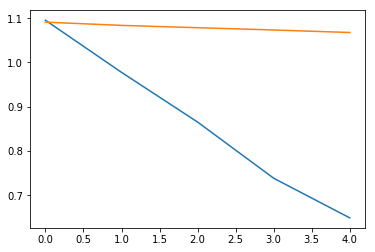

   epoch  train_acc  train_loss  valid_acc  valid_loss
0      1   0.311765    1.095457   0.666667    1.091199
1      2   0.688235    0.977731   0.633333    1.083830
2      3   0.735294    0.865352   0.633333    1.078608
3      4   0.852941    0.738439   0.633333    1.073431
4      5   0.858824    0.648740   0.633333    1.067781


In [26]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              'train_acc': history.history['acc'],
                              'valid_acc': history.history['val_acc'],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})


# In[180]:

summary_stats


# In[181]:

plt.plot(summary_stats.train_loss) # blue
plt.plot(summary_stats.valid_loss) # green
plt.show()
print(summary_stats)

In [244]:
model.save('rentals_weights_2.h5')

In [27]:
predictions = model.predict(features, verbose = True)
# predictions = model.predict(test_features, verbose = True)

128/200 [==================>...........] - ETA: 0s

In [28]:
print(predictions[:20])
print(y_train[:num_rows])

[[ 0.36360624  0.32021013  0.31618357]
 [ 0.34846079  0.33523184  0.31630737]
 [ 0.33954954  0.34467459  0.31577587]
 [ 0.36054981  0.31985459  0.31959563]
 [ 0.32996169  0.34990585  0.3201324 ]
 [ 0.34846079  0.33523184  0.31630737]
 [ 0.32910869  0.35282713  0.31806424]
 [ 0.35986799  0.3256557   0.31447622]
 [ 0.35691047  0.32774806  0.31534153]
 [ 0.37238678  0.30527523  0.32233804]
 [ 0.32746449  0.35392413  0.31861129]
 [ 0.35827318  0.32558155  0.31614533]
 [ 0.35889313  0.32389891  0.31720799]
 [ 0.33291337  0.35007095  0.31701568]
 [ 0.36062774  0.32212529  0.31724694]
 [ 0.3591435   0.32271993  0.31813654]
 [ 0.35874417  0.32419199  0.31706384]
 [ 0.32817131  0.34952301  0.32230568]
 [ 0.34846079  0.33523184  0.31630737]
 [ 0.34846079  0.33523184  0.31630737]]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.

In [247]:
predictions = pd.DataFrame(predictions, columns=['high','medium','low'])

In [248]:
predictions['listing_id'] = pd.DataFrame(test_pd.listing_id.values, columns=['listing_id']).listing_id

In [249]:
predictions_id = predictions

In [192]:
predictions.to_csv("submission.csv")

,listing_id
0,7142618
1,7210040
2,7103890
3,7143442
4,6860601
5,6840081
6,6922337
7,6913616
8,6937820
9,6893933


In [250]:
predictions_id = predictions_id.set_index(['listing_id'])

In [251]:
predictions_id.to_csv("submission.csv")

In [252]:
predictions_id

,high,medium,low
listing_id,,,
7142618,0.695683,0.304317,8.367934e-12
7210040,0.686550,0.313450,6.085356e-13
7103890,0.663537,0.336242,2.210920e-04
7143442,0.663675,0.336168,1.567050e-04
6860601,0.670810,0.329086,1.041242e-04
6840081,0.686748,0.313252,4.160824e-09
6922337,0.676823,0.323176,1.031361e-06
6913616,0.666394,0.333567,3.915112e-05
6937820,0.702452,0.297548,1.660320e-09
